In [1]:
import os.path as osp
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch.hub
import os
import model
from PIL import Image
from torchvision import transforms
from visualize.grad_cam import BackPropagation, GradCAM,GuidedBackPropagation
from IPython import display
import threading
import time
import vlc
from random import seed,random, randint
import pickle

plt.rcParams['figure.dpi'] = 200
%matplotlib inline

In [2]:
# Check CUDA availability 
torch.cuda.is_available()

True

In [3]:
# We loaded the simple face detection model before image processing
faceCascade = cv2.CascadeClassifier('visualize/haarcascade_frontalface_default.xml')

# Input image shape
shape = (48,48)

# Name Classes
classes = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Sad',
    'Surprised',
    'Neutral'
]

# Setting the GPU as the Main Processor Unit
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Hide unnecessary messages
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Pre-processing for face detection before model with opencv
def preprocess(image_path):
    global faceCascade
    global shape
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path)
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    flag =0
    if len(faces) == 0:
        print('no face found')
        face = cv2.resize(image, shape)
    else:
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        face = cv2.resize(face, shape)
        flag=1

    img = Image.fromarray(face).convert('L')
    inputs = transform_test(img)
    return inputs, face, flag

# Plot the results for testing
def plotImage(path, mylabel):
    global shape
    img = cv2.imread(path)
    dimensions = img.shape
    height = img.shape[0]
    width = img.shape[1]
    cv2.putText(img, mylabel,(round(width/2)-40,height-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    cv2.imwrite('temp-images/display.jpg',img) 

# Emotion detection with Pytorch model
def detect_emotion(images, model_name):
    global classes
    global device
    flag=0
    with HiddenPrints():
        for i, image in enumerate(images):
            target, raw_image,flag = preprocess(image['path'])
            image['image'] = target
            image['raw_image'] = raw_image

        net = model.Model(num_classes=len(classes)).to(device)
        checkpoint = torch.load(os.path.join('model', model_name), map_location=device)
        net.load_state_dict(checkpoint['net'])
        net.eval()
        result_images = []
    label = ""
    if(flag):
        for index, image in enumerate(images):
            with HiddenPrints():
                img = torch.stack([image['image']]).to(device)
                bp = BackPropagation(model=net)
                probs, ids = bp.forward(img)
                actual_emotion = ids[:,0]
            label = classes[actual_emotion.data]
        plotImage(image['path'],label)
    else:
        plotImage(image['path'],label)
    return label

In [5]:
# Seed label
with open("label", "wb") as f:
    pickle.dump("", f)

In [6]:
# Thread 1: Emotion detection
def detection():
    global classes
    video_capture = cv2.VideoCapture(0)
    
    while 1:
        ret, frame = video_capture.read()
        cv2.imwrite('temp-images/test.jpg',frame)
        detection = detect_emotion(images=[{'path': 'temp-images/test.jpg'}],model_name='emotions.t7')
        with open("label", "wb") as f:
            pickle.dump(detection, f)
def plot():
    while 1:
        try:
            img=mpimg.imread('temp-images/display.jpg')
            plt.imshow(img)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        except:
            ...
        
# Thread 2: Music control according to detected emotion           
def music():
    global classes
    seed(round(random()*10))
    counter = [0,0,0,0,0,0,0]
    label=""
    # We start the program assuming the person feels neutral
    status="Neutral"
    memstatus=""
    memstatus2=""
    flag = 0
    entries = os.listdir('music/Favs/')
    value = randint(0, len(entries)-1)
    p = vlc.MediaPlayer('music/Favs/'+entries[value])
    p.play()
    while 1:
        # The emotion check is done approximately every 10 seconds
        try:
            with open("label", "rb") as f:
                label = pickle.load(f)
            time.sleep(1)
            y=0
            for x in classes:
                if(x==label):
                    counter[y] = counter[y] + 1
                y = y + 1 
            y=0
            for x in counter:
                if(x == 5):
                    status = classes[y]
                    counter = [0,0,0,0,0,0,0]
                    flag = 1
                    break
                y = y + 1

            """ 
            According to the detected emotion we will randomly reproduce a song from one of our playlists:

            - If the person is angry we will play a song that generates calm
            - If the person is sad, a song for the person to be happy
            - If the person is neutral or happy we will play some of their favorite songs

            Note: If the detected emotion has not changed, the playlist will continue without changing the song.
            """
            if((status=='Angry' and flag and status!=memstatus) or (not(p.is_playing()) and status=='Angry' and flag)):
                seed(round(random()*10))
                memstatus = status
                memstatus2 = ''
                p.stop()
                entries = os.listdir('music/Chill/')
                value = randint(0, len(entries)-1)
                p = vlc.MediaPlayer("music/Chill/"+entries[value])
                p.play()

            elif(((status=='Neutral' or status=='Happy') and flag and status!=memstatus and status!=memstatus2) or (not(p.is_playing()) and (status=='Neutral' or status=='Happy') and flag)):
                seed(round(random()*10))
                memstatus = 'Neutral'
                memstatus2 = 'Happy'
                p.stop()
                entries = os.listdir('music/Favs/')
                value = randint(0, len(entries)-1)
                p = vlc.MediaPlayer('music/Favs/'+entries[value])
                p.play()

            elif((status=='Sad' and flag and status!=memstatus) or (not(p.is_playing()) and status=='Sad' and flag)):
                seed(round(random()*10))
                memstatus = status
                memstatus2 = ''
                p.stop()
                entries = os.listdir('music/Happy/')
                value = randint(0, len(entries)-1)
                p = vlc.MediaPlayer('music/Happy/'+entries[value])
                p.play()
        except:
            ...
        

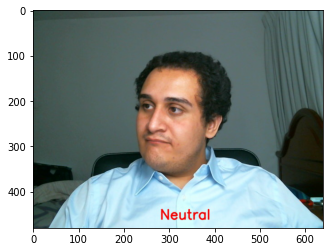

In [7]:
# We take advantage of multiple processing to perform this process more efficiently
            
d = threading.Thread(target=detection, name='detection')
m = threading.Thread(target=music, name='music')
p = threading.Thread(target=plot, name='plot')

d.start()
m.start()
p.start()